# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:07<00:00, 8.37KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

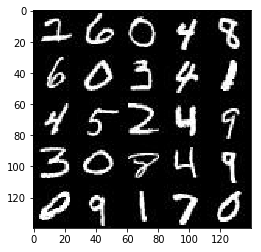

In [2]:
import helper

show_n_images = 25
data_dir = './data'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

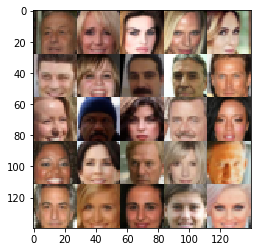

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/home/aladim/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, [None, image_height, image_width, image_channels], name='real_input')
    z_input = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate', shape=())
    
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    #https://medium.com/towards-data-science/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0
    with tf.variable_scope("discriminator", reuse=reuse):
        out1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        relu1 = tf.maximum(alpha * out1, out1)
        drop1 = tf.layers.dropout(relu1, rate=0.4)
        
        out2 = tf.layers.conv2d(drop1, 128, 5, strides=2, padding='SAME')
        norm2 = tf.layers.batch_normalization(out2, training=True)
        relu2 = tf.maximum(alpha * norm2, norm2)
        drop2 = tf.layers.dropout(relu2, rate=0.4)
        
        out3 = tf.layers.conv2d(drop2, 256, 5, strides=2, padding='SAME')
        norm3 = tf.layers.batch_normalization(out3, training=True)
        relu3 = tf.maximum(alpha * norm3, norm3)
        drop3 = tf.layers.dropout(relu3, rate=0.4)
        
        flat = tf.reshape(drop3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    #https://medium.com/towards-data-science/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0
    reuse = not is_train
    
    with tf.variable_scope("generator", reuse=reuse):
        out1 = tf.layers.dense(z, 7*7*512)
        
        out1 = tf.reshape(out1, (-1, 7, 7, 512))
        norm1 = tf.layers.batch_normalization(out1, training=is_train, momentum=0.9)
        relu1 = tf.maximum(alpha * norm1, norm1)
        drop1 = tf.layers.dropout(relu1)
        
        out2 = tf.layers.conv2d_transpose(drop1, 256, 5, strides=2, padding='SAME')
        norm2 = tf.layers.batch_normalization(out2, training=is_train, momentum=0.9)
        relu2 = tf.maximum(alpha * norm2, norm2)

        out3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='SAME')
        norm3 = tf.layers.batch_normalization(out3, training=is_train, momentum=0.9)
        relu3 = tf.maximum(alpha * norm3, norm3)
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding='SAME')
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    #base on DCGAN.ipynb
    ger_model = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(ger_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_model_real) * 0.9))
    dis_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.zeros_like(dis_model_fake)))
    ger_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.ones_like(dis_model_fake)))
    
    dis_loss = dis_loss_real + dis_loss_fake
    
    return dis_loss, ger_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        train_vars = tf.trainable_variables()
        
        dis_vars = [var for var in train_vars if var.name.startswith("discriminator")]
        ger_vars = [var for var in train_vars if var.name.startswith("generator")]

        dis_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        ger_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=ger_vars)
        
    return dis_train, ger_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #based on DCGAN.ipynb
    output_channel_dim = data_shape[3]
    real_input, z_input, tf_learnrate = model_inputs(data_shape[1], data_shape[2], output_channel_dim, z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, output_channel_dim)
    dis_train, ger_train = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for step, batch_images in enumerate(get_batches(batch_size)):
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(dis_train, feed_dict={real_input: batch_images, z_input: batch_z, tf_learnrate: learning_rate})
                _ = sess.run(ger_train, feed_dict={z_input: batch_z, real_input: batch_images, tf_learnrate: learning_rate})
                
                if step % 10 == 0:
                    train_loss_dis = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_ger = g_loss.eval({z_input: batch_z})
                
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_dis),
                          "Generator Loss: {:.4f}".format(train_loss_ger))
                
                number_of_images = 16
                if step % 100 == 0:
                    show_generator_output(sess, number_of_images, z_input, output_channel_dim, data_image_mode)
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 18.6717... Generator Loss: 0.0000


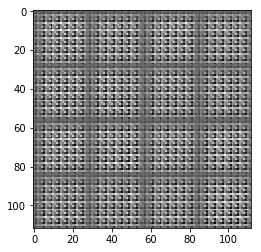

Epoch 1/2... Discriminator Loss: 0.4182... Generator Loss: 5.4010
Epoch 1/2... Discriminator Loss: 0.5502... Generator Loss: 3.8693
Epoch 1/2... Discriminator Loss: 2.5287... Generator Loss: 0.4858
Epoch 1/2... Discriminator Loss: 1.8277... Generator Loss: 5.3548
Epoch 1/2... Discriminator Loss: 0.8926... Generator Loss: 4.6513
Epoch 1/2... Discriminator Loss: 0.9006... Generator Loss: 2.6375
Epoch 1/2... Discriminator Loss: 2.3992... Generator Loss: 0.2634
Epoch 1/2... Discriminator Loss: 1.0552... Generator Loss: 0.9195
Epoch 1/2... Discriminator Loss: 1.1696... Generator Loss: 0.7578
Epoch 1/2... Discriminator Loss: 0.3840... Generator Loss: 3.4520


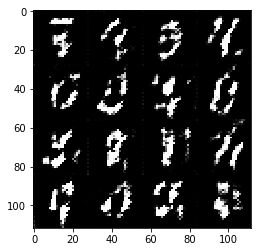

Epoch 1/2... Discriminator Loss: 0.3599... Generator Loss: 3.9124
Epoch 1/2... Discriminator Loss: 0.3512... Generator Loss: 4.6893
Epoch 1/2... Discriminator Loss: 0.3758... Generator Loss: 3.6980
Epoch 1/2... Discriminator Loss: 1.8100... Generator Loss: 13.6448
Epoch 1/2... Discriminator Loss: 1.0764... Generator Loss: 1.9677
Epoch 1/2... Discriminator Loss: 0.4542... Generator Loss: 2.4665
Epoch 1/2... Discriminator Loss: 0.4922... Generator Loss: 2.2867
Epoch 1/2... Discriminator Loss: 0.4226... Generator Loss: 2.9377
Epoch 1/2... Discriminator Loss: 0.4306... Generator Loss: 5.9017
Epoch 1/2... Discriminator Loss: 1.0487... Generator Loss: 5.5744


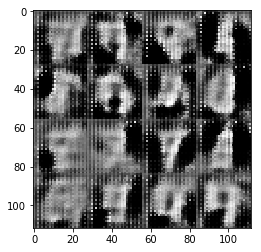

Epoch 1/2... Discriminator Loss: 0.8089... Generator Loss: 1.7625
Epoch 1/2... Discriminator Loss: 0.3768... Generator Loss: 3.9536
Epoch 1/2... Discriminator Loss: 0.7475... Generator Loss: 1.3577
Epoch 1/2... Discriminator Loss: 3.8744... Generator Loss: 0.0513
Epoch 1/2... Discriminator Loss: 0.5434... Generator Loss: 2.2639
Epoch 1/2... Discriminator Loss: 0.3541... Generator Loss: 4.6484
Epoch 1/2... Discriminator Loss: 0.3653... Generator Loss: 3.8274
Epoch 1/2... Discriminator Loss: 0.3676... Generator Loss: 4.0002
Epoch 1/2... Discriminator Loss: 0.3420... Generator Loss: 5.6996
Epoch 1/2... Discriminator Loss: 0.3730... Generator Loss: 3.9811


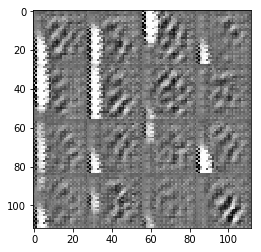

Epoch 1/2... Discriminator Loss: 0.3602... Generator Loss: 4.3106
Epoch 1/2... Discriminator Loss: 0.3348... Generator Loss: 6.3144
Epoch 1/2... Discriminator Loss: 0.3381... Generator Loss: 5.8347
Epoch 1/2... Discriminator Loss: 0.4491... Generator Loss: 3.0344
Epoch 1/2... Discriminator Loss: 1.0345... Generator Loss: 2.4311
Epoch 1/2... Discriminator Loss: 0.4815... Generator Loss: 2.3211
Epoch 1/2... Discriminator Loss: 0.5177... Generator Loss: 2.4768
Epoch 1/2... Discriminator Loss: 0.4458... Generator Loss: 2.6330
Epoch 1/2... Discriminator Loss: 0.4242... Generator Loss: 3.3447
Epoch 1/2... Discriminator Loss: 0.3531... Generator Loss: 4.6426


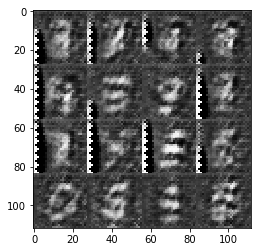

Epoch 1/2... Discriminator Loss: 0.3616... Generator Loss: 4.4722
Epoch 1/2... Discriminator Loss: 0.3459... Generator Loss: 4.6947
Epoch 1/2... Discriminator Loss: 0.5252... Generator Loss: 2.3503
Epoch 1/2... Discriminator Loss: 1.0485... Generator Loss: 0.9695
Epoch 1/2... Discriminator Loss: 0.4492... Generator Loss: 2.8366
Epoch 1/2... Discriminator Loss: 0.5840... Generator Loss: 2.0724
Epoch 1/2... Discriminator Loss: 1.4424... Generator Loss: 0.7796
Epoch 1/2... Discriminator Loss: 0.4100... Generator Loss: 3.2667
Epoch 1/2... Discriminator Loss: 0.3938... Generator Loss: 3.4847
Epoch 1/2... Discriminator Loss: 0.3661... Generator Loss: 4.3388


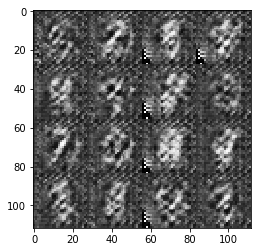

Epoch 1/2... Discriminator Loss: 0.3756... Generator Loss: 3.4295
Epoch 1/2... Discriminator Loss: 0.3465... Generator Loss: 5.4740
Epoch 1/2... Discriminator Loss: 0.4399... Generator Loss: 3.1219
Epoch 1/2... Discriminator Loss: 0.3598... Generator Loss: 4.8762
Epoch 1/2... Discriminator Loss: 0.3438... Generator Loss: 4.9415
Epoch 1/2... Discriminator Loss: 0.8032... Generator Loss: 1.4147
Epoch 1/2... Discriminator Loss: 0.5313... Generator Loss: 2.0023
Epoch 1/2... Discriminator Loss: 0.8670... Generator Loss: 1.2045
Epoch 1/2... Discriminator Loss: 0.3639... Generator Loss: 4.7771
Epoch 1/2... Discriminator Loss: 0.3890... Generator Loss: 3.8282


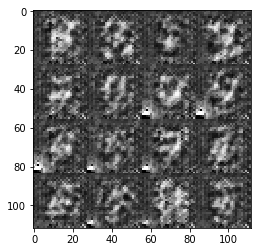

Epoch 1/2... Discriminator Loss: 0.3546... Generator Loss: 4.8946
Epoch 1/2... Discriminator Loss: 0.3813... Generator Loss: 4.0568
Epoch 1/2... Discriminator Loss: 0.4180... Generator Loss: 3.5312
Epoch 1/2... Discriminator Loss: 0.3796... Generator Loss: 3.6899
Epoch 1/2... Discriminator Loss: 0.3417... Generator Loss: 6.1360
Epoch 1/2... Discriminator Loss: 0.4190... Generator Loss: 4.2490
Epoch 1/2... Discriminator Loss: 0.7814... Generator Loss: 1.7616
Epoch 1/2... Discriminator Loss: 0.6529... Generator Loss: 1.7923
Epoch 1/2... Discriminator Loss: 1.9452... Generator Loss: 0.3138
Epoch 1/2... Discriminator Loss: 3.1307... Generator Loss: 6.5337


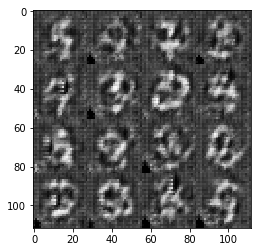

Epoch 1/2... Discriminator Loss: 1.1457... Generator Loss: 0.8600
Epoch 1/2... Discriminator Loss: 1.0381... Generator Loss: 0.9395
Epoch 1/2... Discriminator Loss: 0.9353... Generator Loss: 1.3483
Epoch 1/2... Discriminator Loss: 1.1974... Generator Loss: 0.7285
Epoch 1/2... Discriminator Loss: 0.8211... Generator Loss: 1.4197
Epoch 1/2... Discriminator Loss: 0.4267... Generator Loss: 3.5431
Epoch 1/2... Discriminator Loss: 0.4890... Generator Loss: 2.9137
Epoch 1/2... Discriminator Loss: 0.5052... Generator Loss: 2.6867
Epoch 1/2... Discriminator Loss: 0.8103... Generator Loss: 1.6982
Epoch 1/2... Discriminator Loss: 0.3705... Generator Loss: 3.9992


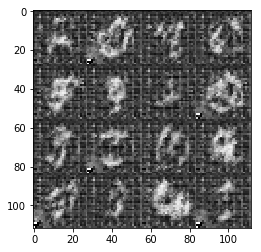

Epoch 1/2... Discriminator Loss: 0.3407... Generator Loss: 5.6875
Epoch 1/2... Discriminator Loss: 0.3382... Generator Loss: 6.5280
Epoch 1/2... Discriminator Loss: 0.3348... Generator Loss: 6.1485
Epoch 1/2... Discriminator Loss: 0.3761... Generator Loss: 4.1083
Epoch 1/2... Discriminator Loss: 0.4692... Generator Loss: 4.1876
Epoch 1/2... Discriminator Loss: 2.6886... Generator Loss: 0.2368
Epoch 1/2... Discriminator Loss: 1.0609... Generator Loss: 0.8563
Epoch 1/2... Discriminator Loss: 0.3855... Generator Loss: 4.3281
Epoch 1/2... Discriminator Loss: 0.3904... Generator Loss: 3.5950
Epoch 1/2... Discriminator Loss: 0.3732... Generator Loss: 3.9224


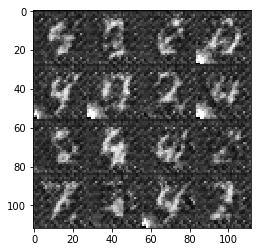

Epoch 1/2... Discriminator Loss: 0.3824... Generator Loss: 3.4892
Epoch 1/2... Discriminator Loss: 0.3867... Generator Loss: 3.6330
Epoch 1/2... Discriminator Loss: 0.3943... Generator Loss: 3.3863
Epoch 2/2... Discriminator Loss: 0.3965... Generator Loss: 3.0795


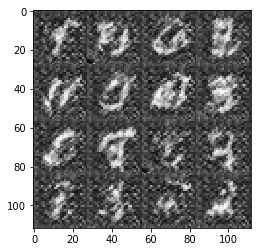

Epoch 2/2... Discriminator Loss: 0.7102... Generator Loss: 1.4361
Epoch 2/2... Discriminator Loss: 1.0154... Generator Loss: 0.9626
Epoch 2/2... Discriminator Loss: 0.7469... Generator Loss: 1.4369
Epoch 2/2... Discriminator Loss: 1.1681... Generator Loss: 2.0524
Epoch 2/2... Discriminator Loss: 1.1991... Generator Loss: 1.5846
Epoch 2/2... Discriminator Loss: 0.8589... Generator Loss: 1.2165
Epoch 2/2... Discriminator Loss: 0.7521... Generator Loss: 1.9398
Epoch 2/2... Discriminator Loss: 0.7761... Generator Loss: 1.7488
Epoch 2/2... Discriminator Loss: 0.8681... Generator Loss: 2.0295
Epoch 2/2... Discriminator Loss: 0.5564... Generator Loss: 2.0787


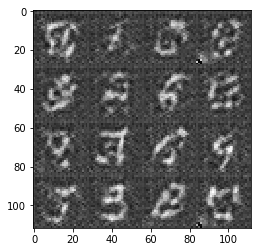

Epoch 2/2... Discriminator Loss: 0.4697... Generator Loss: 2.6957
Epoch 2/2... Discriminator Loss: 2.6558... Generator Loss: 0.2100
Epoch 2/2... Discriminator Loss: 1.6860... Generator Loss: 4.6695
Epoch 2/2... Discriminator Loss: 2.6098... Generator Loss: 0.1531
Epoch 2/2... Discriminator Loss: 0.6208... Generator Loss: 1.7633
Epoch 2/2... Discriminator Loss: 1.6462... Generator Loss: 0.4267
Epoch 2/2... Discriminator Loss: 0.6228... Generator Loss: 1.5984
Epoch 2/2... Discriminator Loss: 0.3476... Generator Loss: 4.7067
Epoch 2/2... Discriminator Loss: 0.9579... Generator Loss: 5.3597
Epoch 2/2... Discriminator Loss: 1.3648... Generator Loss: 0.5318


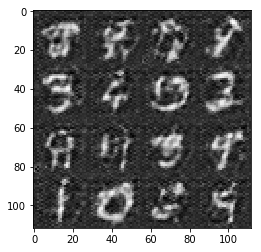

Epoch 2/2... Discriminator Loss: 0.7040... Generator Loss: 1.6138
Epoch 2/2... Discriminator Loss: 1.9659... Generator Loss: 0.3582
Epoch 2/2... Discriminator Loss: 0.7640... Generator Loss: 1.7513
Epoch 2/2... Discriminator Loss: 0.6450... Generator Loss: 5.3566
Epoch 2/2... Discriminator Loss: 0.4613... Generator Loss: 2.2868
Epoch 2/2... Discriminator Loss: 0.3765... Generator Loss: 3.7113
Epoch 2/2... Discriminator Loss: 0.3927... Generator Loss: 3.1346
Epoch 2/2... Discriminator Loss: 0.3984... Generator Loss: 2.9488
Epoch 2/2... Discriminator Loss: 0.7527... Generator Loss: 4.2758
Epoch 2/2... Discriminator Loss: 0.8651... Generator Loss: 1.1340


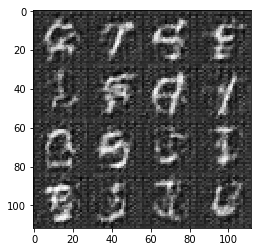

Epoch 2/2... Discriminator Loss: 0.7910... Generator Loss: 1.3059
Epoch 2/2... Discriminator Loss: 0.5886... Generator Loss: 1.7250
Epoch 2/2... Discriminator Loss: 0.4949... Generator Loss: 2.0770
Epoch 2/2... Discriminator Loss: 1.6658... Generator Loss: 2.2604
Epoch 2/2... Discriminator Loss: 1.0740... Generator Loss: 0.7839
Epoch 2/2... Discriminator Loss: 0.4067... Generator Loss: 2.9264
Epoch 2/2... Discriminator Loss: 0.4505... Generator Loss: 2.6708
Epoch 2/2... Discriminator Loss: 0.4144... Generator Loss: 3.3963
Epoch 2/2... Discriminator Loss: 0.4342... Generator Loss: 2.8453
Epoch 2/2... Discriminator Loss: 0.3585... Generator Loss: 4.7025


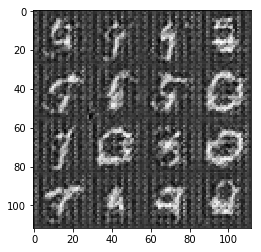

Epoch 2/2... Discriminator Loss: 0.3566... Generator Loss: 6.4329
Epoch 2/2... Discriminator Loss: 0.3680... Generator Loss: 3.6437
Epoch 2/2... Discriminator Loss: 0.3789... Generator Loss: 3.3137
Epoch 2/2... Discriminator Loss: 0.3727... Generator Loss: 3.4362
Epoch 2/2... Discriminator Loss: 0.7143... Generator Loss: 1.2806
Epoch 2/2... Discriminator Loss: 0.7301... Generator Loss: 1.7697
Epoch 2/2... Discriminator Loss: 1.0327... Generator Loss: 0.8601
Epoch 2/2... Discriminator Loss: 0.5668... Generator Loss: 1.9329
Epoch 2/2... Discriminator Loss: 1.6047... Generator Loss: 0.4591
Epoch 2/2... Discriminator Loss: 0.8521... Generator Loss: 1.3014


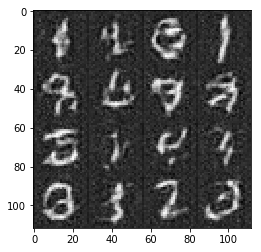

Epoch 2/2... Discriminator Loss: 0.8380... Generator Loss: 1.5031
Epoch 2/2... Discriminator Loss: 0.7686... Generator Loss: 1.1990
Epoch 2/2... Discriminator Loss: 0.6808... Generator Loss: 1.8939
Epoch 2/2... Discriminator Loss: 0.3634... Generator Loss: 3.9626
Epoch 2/2... Discriminator Loss: 0.4074... Generator Loss: 2.8265
Epoch 2/2... Discriminator Loss: 0.3841... Generator Loss: 3.2756
Epoch 2/2... Discriminator Loss: 1.0557... Generator Loss: 3.5570
Epoch 2/2... Discriminator Loss: 0.3721... Generator Loss: 3.9502
Epoch 2/2... Discriminator Loss: 0.3895... Generator Loss: 3.4009
Epoch 2/2... Discriminator Loss: 0.4426... Generator Loss: 2.4536


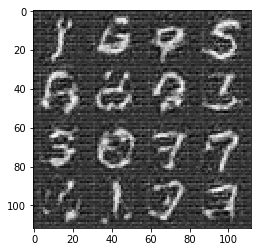

Epoch 2/2... Discriminator Loss: 0.4687... Generator Loss: 3.9043
Epoch 2/2... Discriminator Loss: 0.3703... Generator Loss: 3.5054
Epoch 2/2... Discriminator Loss: 0.4134... Generator Loss: 2.9185
Epoch 2/2... Discriminator Loss: 0.3662... Generator Loss: 4.3022
Epoch 2/2... Discriminator Loss: 1.0905... Generator Loss: 0.9541
Epoch 2/2... Discriminator Loss: 0.7997... Generator Loss: 1.1213
Epoch 2/2... Discriminator Loss: 0.4672... Generator Loss: 2.3155
Epoch 2/2... Discriminator Loss: 1.3921... Generator Loss: 0.6333
Epoch 2/2... Discriminator Loss: 0.8824... Generator Loss: 1.1121
Epoch 2/2... Discriminator Loss: 0.8082... Generator Loss: 1.4365


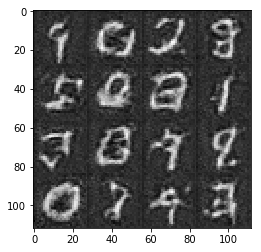

Epoch 2/2... Discriminator Loss: 0.9593... Generator Loss: 0.9929
Epoch 2/2... Discriminator Loss: 0.8672... Generator Loss: 1.1660
Epoch 2/2... Discriminator Loss: 0.5292... Generator Loss: 1.9798
Epoch 2/2... Discriminator Loss: 0.3607... Generator Loss: 4.6074
Epoch 2/2... Discriminator Loss: 0.4110... Generator Loss: 2.8145
Epoch 2/2... Discriminator Loss: 1.2695... Generator Loss: 2.6994
Epoch 2/2... Discriminator Loss: 1.6060... Generator Loss: 0.3972
Epoch 2/2... Discriminator Loss: 1.8267... Generator Loss: 3.8771
Epoch 2/2... Discriminator Loss: 1.5771... Generator Loss: 0.4395
Epoch 2/2... Discriminator Loss: 1.2329... Generator Loss: 3.3491


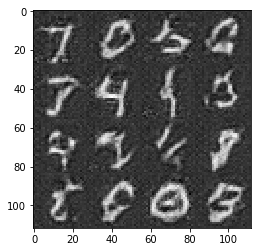

Epoch 2/2... Discriminator Loss: 0.5673... Generator Loss: 3.4825
Epoch 2/2... Discriminator Loss: 1.2626... Generator Loss: 0.6115
Epoch 2/2... Discriminator Loss: 0.6627... Generator Loss: 4.9761
Epoch 2/2... Discriminator Loss: 1.6572... Generator Loss: 0.4004
Epoch 2/2... Discriminator Loss: 0.5135... Generator Loss: 2.3783
Epoch 2/2... Discriminator Loss: 0.7756... Generator Loss: 1.3495
Epoch 2/2... Discriminator Loss: 0.7779... Generator Loss: 1.2754
Epoch 2/2... Discriminator Loss: 0.4645... Generator Loss: 2.7426
Epoch 2/2... Discriminator Loss: 0.5808... Generator Loss: 1.6837
Epoch 2/2... Discriminator Loss: 1.0099... Generator Loss: 0.8318


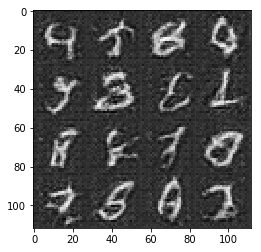

Epoch 2/2... Discriminator Loss: 0.8194... Generator Loss: 1.3862
Epoch 2/2... Discriminator Loss: 0.4782... Generator Loss: 2.3555
Epoch 2/2... Discriminator Loss: 0.3647... Generator Loss: 3.8309


In [ ]:
batch_size = 64
z_dim = 120
learning_rate = 0.001
beta1 = 0.4

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 13.7246... Generator Loss: 0.0000


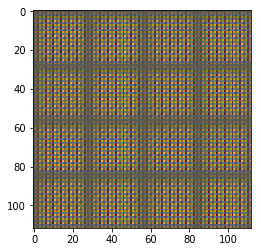

Epoch 1/1... Discriminator Loss: 0.3975... Generator Loss: 4.0804
Epoch 1/1... Discriminator Loss: 0.4836... Generator Loss: 9.0739
Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 12.4028
Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 0.7607... Generator Loss: 1.7192
Epoch 1/1... Discriminator Loss: 0.7485... Generator Loss: 1.5387
Epoch 1/1... Discriminator Loss: 0.5628... Generator Loss: 2.2553
Epoch 1/1... Discriminator Loss: 0.5386... Generator Loss: 2.5217
Epoch 1/1... Discriminator Loss: 0.4141... Generator Loss: 3.1790
Epoch 1/1... Discriminator Loss: 0.3584... Generator Loss: 4.3951


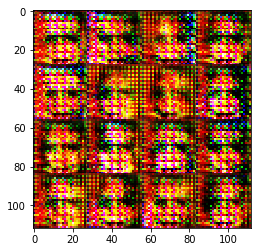

Epoch 1/1... Discriminator Loss: 0.3467... Generator Loss: 5.2537
Epoch 1/1... Discriminator Loss: 0.3807... Generator Loss: 4.2883
Epoch 1/1... Discriminator Loss: 0.3635... Generator Loss: 4.3178
Epoch 1/1... Discriminator Loss: 0.3766... Generator Loss: 5.3173
Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 3.9523
Epoch 1/1... Discriminator Loss: 0.5362... Generator Loss: 2.1614
Epoch 1/1... Discriminator Loss: 0.4395... Generator Loss: 2.5971
Epoch 1/1... Discriminator Loss: 0.3507... Generator Loss: 4.5753
Epoch 1/1... Discriminator Loss: 0.4410... Generator Loss: 2.5656
Epoch 1/1... Discriminator Loss: 5.2560... Generator Loss: 5.9320


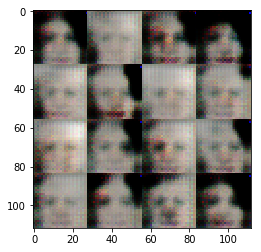

Epoch 1/1... Discriminator Loss: 1.1262... Generator Loss: 1.0162
Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 1.3377
Epoch 1/1... Discriminator Loss: 0.6864... Generator Loss: 1.5250
Epoch 1/1... Discriminator Loss: 0.5122... Generator Loss: 2.1933
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 1.2083
Epoch 1/1... Discriminator Loss: 0.5101... Generator Loss: 2.1443
Epoch 1/1... Discriminator Loss: 0.6313... Generator Loss: 3.0828
Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 1.2979
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 0.5878... Generator Loss: 2.5366


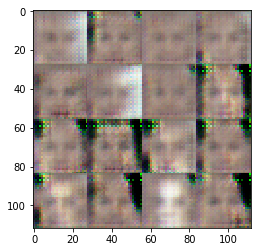

Epoch 1/1... Discriminator Loss: 0.8021... Generator Loss: 1.6639
Epoch 1/1... Discriminator Loss: 0.4430... Generator Loss: 2.8232
Epoch 1/1... Discriminator Loss: 0.6600... Generator Loss: 3.9759
Epoch 1/1... Discriminator Loss: 0.6854... Generator Loss: 2.1940
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 1.3513
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 1.0847
Epoch 1/1... Discriminator Loss: 0.5706... Generator Loss: 2.3021
Epoch 1/1... Discriminator Loss: 0.6076... Generator Loss: 2.4784
Epoch 1/1... Discriminator Loss: 0.5251... Generator Loss: 2.6012
Epoch 1/1... Discriminator Loss: 1.9944... Generator Loss: 0.5967


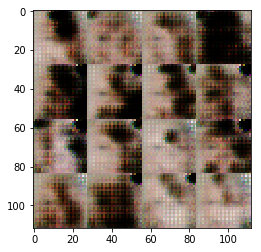

Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 0.8881... Generator Loss: 1.6217
Epoch 1/1... Discriminator Loss: 0.7153... Generator Loss: 1.5175
Epoch 1/1... Discriminator Loss: 0.4849... Generator Loss: 2.9011
Epoch 1/1... Discriminator Loss: 0.4758... Generator Loss: 2.6352
Epoch 1/1... Discriminator Loss: 0.5173... Generator Loss: 3.8355
Epoch 1/1... Discriminator Loss: 0.5340... Generator Loss: 2.9157
Epoch 1/1... Discriminator Loss: 0.4626... Generator Loss: 2.8922
Epoch 1/1... Discriminator Loss: 0.4981... Generator Loss: 2.9757
Epoch 1/1... Discriminator Loss: 0.6853... Generator Loss: 2.0953


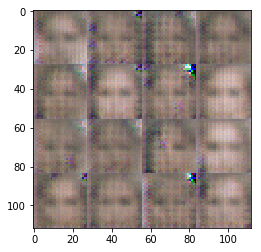

Epoch 1/1... Discriminator Loss: 0.9247... Generator Loss: 1.7848
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 1.5001
Epoch 1/1... Discriminator Loss: 1.7269... Generator Loss: 1.9636
Epoch 1/1... Discriminator Loss: 0.6073... Generator Loss: 2.4368
Epoch 1/1... Discriminator Loss: 0.4852... Generator Loss: 2.7439
Epoch 1/1... Discriminator Loss: 0.4761... Generator Loss: 2.5932
Epoch 1/1... Discriminator Loss: 0.6192... Generator Loss: 1.8697
Epoch 1/1... Discriminator Loss: 0.5686... Generator Loss: 2.1129
Epoch 1/1... Discriminator Loss: 0.5179... Generator Loss: 2.5017
Epoch 1/1... Discriminator Loss: 0.4137... Generator Loss: 3.3054


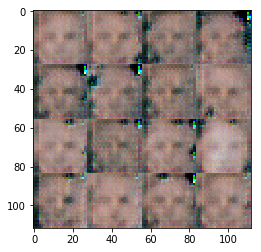

Epoch 1/1... Discriminator Loss: 2.0833... Generator Loss: 1.8718
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 0.4660... Generator Loss: 2.9256
Epoch 1/1... Discriminator Loss: 0.5504... Generator Loss: 2.3096
Epoch 1/1... Discriminator Loss: 0.5024... Generator Loss: 3.0296
Epoch 1/1... Discriminator Loss: 0.9833... Generator Loss: 1.0941
Epoch 1/1... Discriminator Loss: 0.4380... Generator Loss: 3.1803
Epoch 1/1... Discriminator Loss: 0.4382... Generator Loss: 3.0106
Epoch 1/1... Discriminator Loss: 0.4400... Generator Loss: 3.0951
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 1.0800


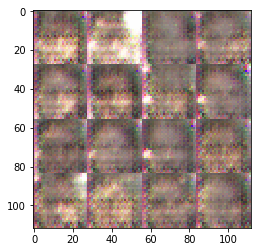

Epoch 1/1... Discriminator Loss: 0.7657... Generator Loss: 1.3459
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 1.0722
Epoch 1/1... Discriminator Loss: 0.4391... Generator Loss: 2.9809
Epoch 1/1... Discriminator Loss: 0.4053... Generator Loss: 3.3322
Epoch 1/1... Discriminator Loss: 0.3595... Generator Loss: 4.1438
Epoch 1/1... Discriminator Loss: 0.3778... Generator Loss: 3.6243
Epoch 1/1... Discriminator Loss: 0.3549... Generator Loss: 4.1163
Epoch 1/1... Discriminator Loss: 0.3535... Generator Loss: 4.6220
Epoch 1/1... Discriminator Loss: 0.3720... Generator Loss: 3.8848
Epoch 1/1... Discriminator Loss: 0.5589... Generator Loss: 3.9312


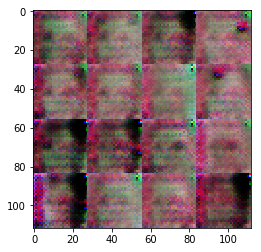

Epoch 1/1... Discriminator Loss: 1.6448... Generator Loss: 1.0767
Epoch 1/1... Discriminator Loss: 1.5965... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.9690
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 1.2469
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 0.5924... Generator Loss: 2.1739
Epoch 1/1... Discriminator Loss: 0.5004... Generator Loss: 2.4822
Epoch 1/1... Discriminator Loss: 0.6612... Generator Loss: 1.6425
Epoch 1/1... Discriminator Loss: 0.3934... Generator Loss: 3.4260


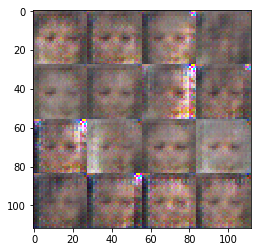

Epoch 1/1... Discriminator Loss: 0.4253... Generator Loss: 2.7770
Epoch 1/1... Discriminator Loss: 0.3681... Generator Loss: 3.7646
Epoch 1/1... Discriminator Loss: 0.3940... Generator Loss: 3.4507
Epoch 1/1... Discriminator Loss: 0.4109... Generator Loss: 3.1662
Epoch 1/1... Discriminator Loss: 0.4237... Generator Loss: 3.0965
Epoch 1/1... Discriminator Loss: 0.3743... Generator Loss: 3.8695
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 5.9892
Epoch 1/1... Discriminator Loss: 1.5652... Generator Loss: 0.5479
Epoch 1/1... Discriminator Loss: 0.4021... Generator Loss: 3.4702
Epoch 1/1... Discriminator Loss: 2.0572... Generator Loss: 5.4887


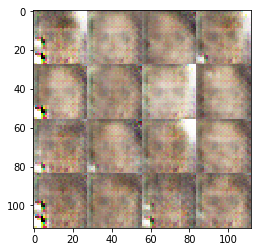

Epoch 1/1... Discriminator Loss: 0.4445... Generator Loss: 2.6965
Epoch 1/1... Discriminator Loss: 0.6694... Generator Loss: 1.4297
Epoch 1/1... Discriminator Loss: 0.8867... Generator Loss: 1.4612
Epoch 1/1... Discriminator Loss: 0.6412... Generator Loss: 1.6863
Epoch 1/1... Discriminator Loss: 0.4174... Generator Loss: 2.7857
Epoch 1/1... Discriminator Loss: 0.3487... Generator Loss: 4.7380
Epoch 1/1... Discriminator Loss: 0.4969... Generator Loss: 2.1899
Epoch 1/1... Discriminator Loss: 0.6704... Generator Loss: 1.8743
Epoch 1/1... Discriminator Loss: 0.4206... Generator Loss: 3.2733
Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 1.8970


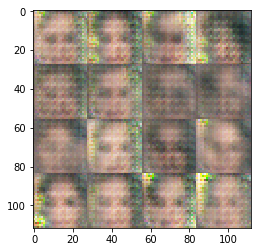

Epoch 1/1... Discriminator Loss: 0.8296... Generator Loss: 1.1512
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.9285
Epoch 1/1... Discriminator Loss: 0.8082... Generator Loss: 1.2755
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 0.4947... Generator Loss: 2.4466
Epoch 1/1... Discriminator Loss: 1.5349... Generator Loss: 2.5178
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 1.8944... Generator Loss: 2.7738
Epoch 1/1... Discriminator Loss: 1.5230... Generator Loss: 0.7447


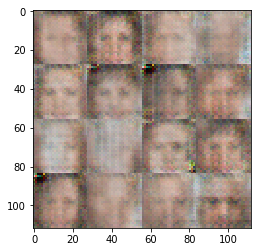

Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 1.0118
Epoch 1/1... Discriminator Loss: 1.6730... Generator Loss: 1.0269
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.5373... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 1.5664... Generator Loss: 1.2453
Epoch 1/1... Discriminator Loss: 0.7711... Generator Loss: 1.1269
Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 1.5210... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.8391... Generator Loss: 1.8914
Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 1.0243


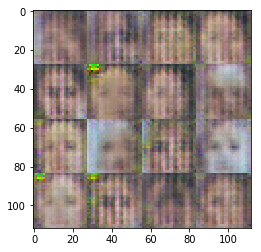

Epoch 1/1... Discriminator Loss: 0.6590... Generator Loss: 1.6298
Epoch 1/1... Discriminator Loss: 2.5617... Generator Loss: 2.4168
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 1.0394
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 1.0728
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 1.0570
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.8484
Epoch 1/1... Discriminator Loss: 0.6475... Generator Loss: 1.4217


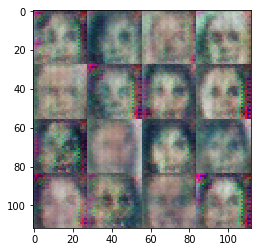

Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.9411
Epoch 1/1... Discriminator Loss: 1.7640... Generator Loss: 0.3311
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 1.0557
Epoch 1/1... Discriminator Loss: 2.4914... Generator Loss: 2.2611
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.5404
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.6900


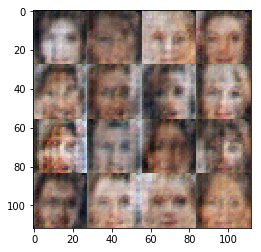

Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.7148... Generator Loss: 1.3697
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.6342... Generator Loss: 0.4576
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 1.0875
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.5707


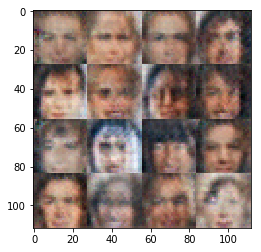

Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 1.0594
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 1.0247
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.9552
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.7754


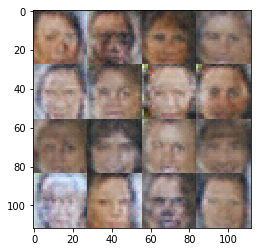

Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.7957... Generator Loss: 0.2842
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 1.1022
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.5935
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.7074


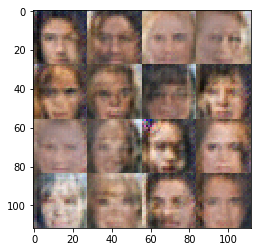

Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.5371... Generator Loss: 1.0831
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 1.1518
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.7454


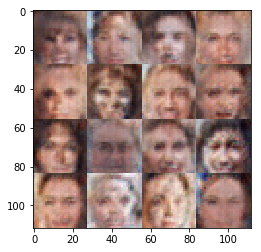

Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.6731


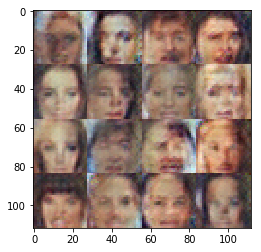

Epoch 1/1... Discriminator Loss: 1.5872... Generator Loss: 2.4487
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.6078... Generator Loss: 0.5185
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.5861


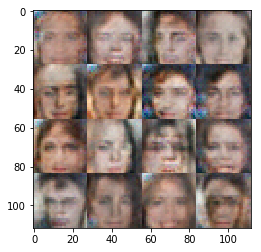

Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.5055... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.6396... Generator Loss: 0.4481
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.9694
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.5703
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 1.0783


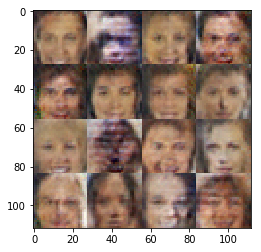

Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 1.0098
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.5508
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.5394... Generator Loss: 0.4425
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.5981
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.8872
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.5887


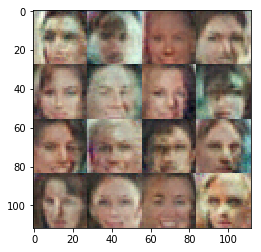

Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 1.4258
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.9868
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.5136... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.5566
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.8719


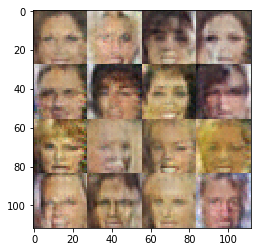

Epoch 1/1... Discriminator Loss: 1.5045... Generator Loss: 0.5211
Epoch 1/1... Discriminator Loss: 1.5619... Generator Loss: 0.4691
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.9641
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.8295


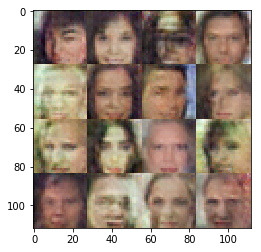

Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.9757
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 1.2151
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.5350... Generator Loss: 0.4779
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.9836


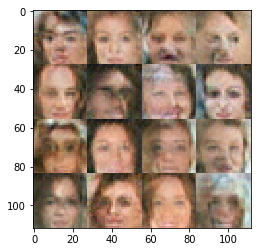

Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 1.3472
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 0.9334... Generator Loss: 1.1048
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 0.9899
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.8070


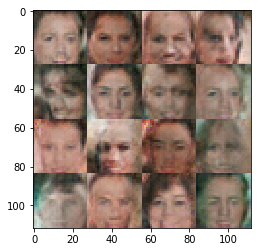

Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 1.0111
Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 1.9638
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 1.0810
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.4909
Epoch 1/1... Discriminator Loss: 1.7596... Generator Loss: 0.4636
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.9600
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.9916
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.6396


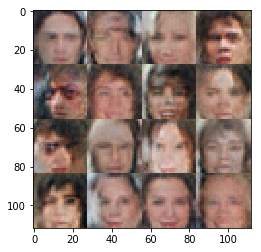

Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 1.0331
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.5121
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.7481... Generator Loss: 0.3069
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.5734


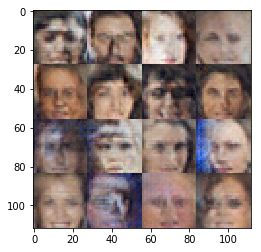

Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.7675


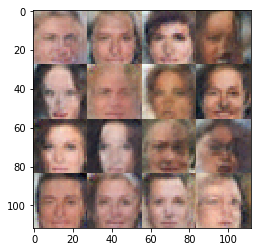

Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 1.3967
Epoch 1/1... Discriminator Loss: 1.5001... Generator Loss: 0.5320
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.6319... Generator Loss: 0.5951
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.7628


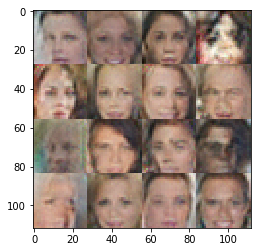

Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.5246
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.5603
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 0.5196


In [12]:
batch_size = 64
z_dim = 120
learning_rate = 0.001
beta1 = 0.4

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.